<a href="https://colab.research.google.com/github/TivsLThree/CAP-4630-Artificial-Intelligence/blob/master/Homework/HW4/HW4V2_pretrained_convnet_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning VGG16 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-16 22:04:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c0e::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  45.9MB/s    in 1.4s    

2020-04-16 22:04:19 (45.9 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with VGG16 convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.applications import Xception
# Change the conv_base
#conv_base = VGG16(
#    weights='imagenet', 
#    include_top=False, 
#    input_shape=(150, 150, 3))
#conv_base = ResNet50( # didn't like these results
#    include_top = False, 
#    weights = 'imagenet', 
#    input_shape=(150,150,3))
conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

Reasoning for choices:
Initially tried to lower the lr to 1e-6 but this was causing the val_acc to stay at .5 and also reduced other metrics. 1e-5 works well. The lower lr DOES work after unfreezing the conv_base layers. I assume this is because there are more trainable weights then so even if the lr is small it still effects a lot more. 
I attempted to lower the amount of nodes in the dense layers but this lead to severe underfitting

Additionally, these changes were made with the ResNet50 model. After changing to Xception the results have been much better. 

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
# I tried adding another dense and dropout layer with ResNet50 but the results were poor
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_14 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

## Train the model end to end with frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy',  
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 20s 203ms/step - loss: 0.4689 - acc: 0.7625 - val_loss: 0.2264 - val_acc: 0.9270
Epoch 2/30
100/100 [==============================] - 18s 175ms/step - loss: 0.3864 - acc: 0.8190 - val_loss: 0.0206 - val_acc: 0.9660
Epoch 3/30
100/100 [==============================] - 17s 174ms/step - loss: 0.3632 - acc: 0.8320 - val_loss: 0.2034 - val_acc: 0.9670
Epoch 4/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3477 - acc: 0.8365 - val_loss: 0.0048 - val_acc: 0.9660
Epoch 5/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3438 - acc: 0.8385 - val_loss: 0.0116 - val_acc: 0.9710
Epoch 6/30
100/100 [==============================] - 17s 173ms/step - loss: 0.3167 - acc: 0.8495 - val_loss: 0.2483 - val_acc: 0.9670
Epoch 7/30
100/100 [==============================] - 17s 173ms/step - loss: 0.3232 - acc: 0.8470 - val_lo

## Display curves of loss and accuracy during training

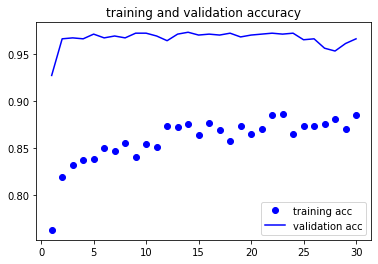

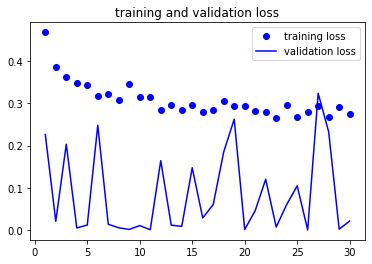

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True


for layer in conv_base.layers:
  if layer.name == 'block1_conv1' or layer.name == 'block1_conv2':
    layer.trainable = True;

In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-6), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 33s 328ms/step - loss: 0.2560 - acc: 0.8855 - val_loss: 0.1100 - val_acc: 0.9430
Epoch 2/100
100/100 [==============================] - 23s 233ms/step - loss: 0.2581 - acc: 0.8815 - val_loss: 0.0587 - val_acc: 0.9350
Epoch 3/100
100/100 [==============================] - 23s 233ms/step - loss: 0.2600 - acc: 0.8840 - val_loss: 0.0239 - val_acc: 0.9380
Epoch 4/100
100/100 [==============================] - 23s 233ms/step - loss: 0.2545 - acc: 0.8890 - val_loss: 0.3018 - val_acc: 0.9410
Epoch 5/100
100/100 [==============================] - 24s 235ms/step - loss: 0.2396 - acc: 0.8955 - val_loss: 0.4008 - val_acc: 0.9400
Epoch 6/100
100/100 [==============================] - 23s 232ms/step - loss: 0.2342 - acc: 0.8970 - val_loss: 0.2743 - val_acc: 0.9380
Epoch 7/100
100/100 [==============================] - 23s 234ms/step - loss: 0.2330 - acc: 0.8990 - val_loss: 0.4280 - val_acc: 0.9390
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

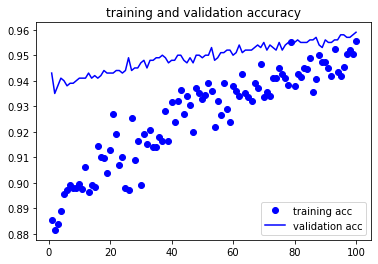

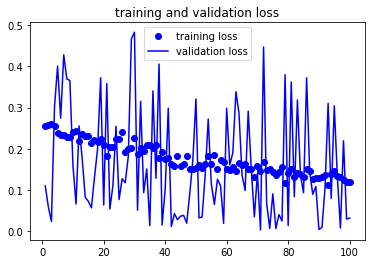

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

It seems to me that both training acc and validation acc are trending upwards. Over the course of training, validation acc went up from .88 to .95

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.03202635049819946
Validation accuracy: 0.9589999914169312


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)

KeyboardInterrupt: ignored